# JSON Serialization

In [1]:
import numpy as np
import pulser
from pulser import Pulse, Sequence, Register
from pulser.waveforms import BlackmanWaveform
from pulser.devices import Chadoq2

Often times, it is useful to import/export a given `Sequence` between different locations. To enable this, the `Sequence` object supports **serialization** and **deserialization** into JSON-formatted strings. This will work for any given `Sequence`. Take for example, this sequence that creates the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$:

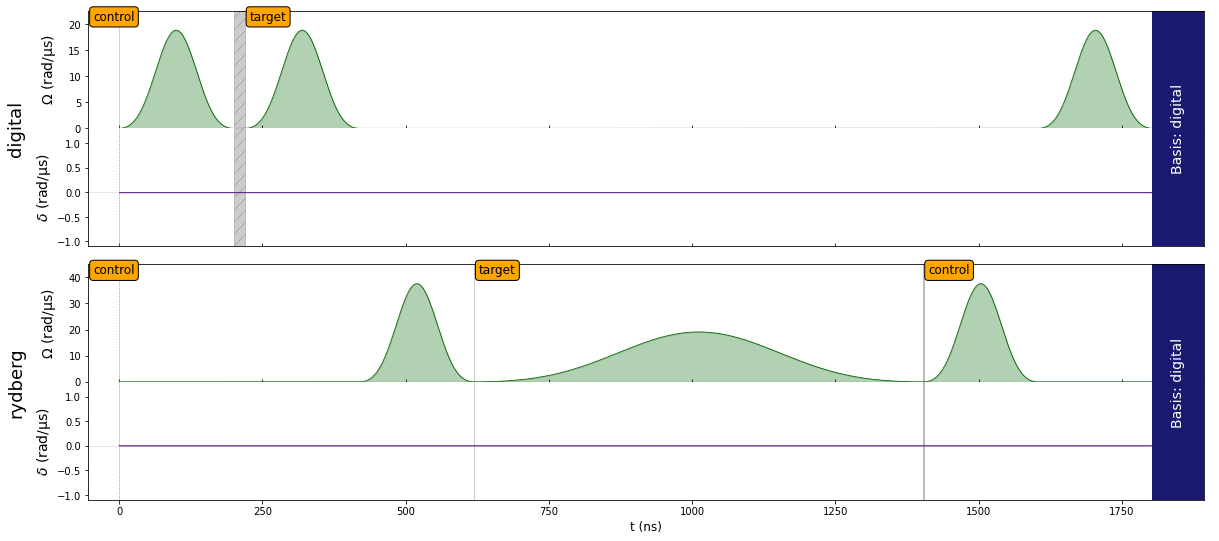

In [2]:
qubits = {"control": (-2, 0), "target": (2, 0)}
reg = Register(qubits)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("digital", "raman_local", initial_target="control")
seq.declare_channel("rydberg", "rydberg_local", initial_target="control")

half_pi_wf = BlackmanWaveform(200, np.pi/2)

ry = Pulse.ConstantDetuning(amplitude=half_pi_wf,detuning=0,phase=-np.pi/2)
ry_dag = Pulse.ConstantDetuning(amplitude=half_pi_wf,detuning=0,phase=np.pi/2)

seq.add(ry, "digital")
seq.target("target", "digital")
seq.add(ry_dag, "digital")

pi_wf = BlackmanWaveform(200, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

max_val = Chadoq2.rabi_from_blockade(8)
two_pi_wf = BlackmanWaveform.from_max_val(max_val, 2*np.pi)
two_pi_pulse = Pulse.ConstantDetuning(two_pi_wf, 0, 0)

seq.align("digital", "rydberg")
seq.add(pi_pulse, "rydberg")
seq.target("target", "rydberg")
seq.add(two_pi_pulse, "rydberg")
seq.target("control", "rydberg")
seq.add(pi_pulse, "rydberg")

seq.align("digital", "rydberg")
seq.add(ry, "digital")
seq.measure("digital")
seq.draw()

## Serialize

To serialize it, we simply call:

In [3]:
s = seq.serialize()

which outputs the JSON-formatted string encoding the sequence. Although it is not particularly human-readable in its most compact form, let's look at the first 100 characters to check that it's actually a string:

In [4]:
print(s[:100], "...")

{"_build": true, "__module__": "pulser.sequence", "__name__": "Sequence", "__args__": [{"_build": tr ...


If we want to read it, we can also make it prettier by changing the indentation. This is done through one of the optional arguments of `json.dumps`, which we can specify in `Sequence.serialize()`.

In [5]:
print(seq.serialize(indent=1)[:100], "...")

{
 "_build": true,
 "__module__": "pulser.sequence",
 "__name__": "Sequence",
 "__args__": [
  {
    ...


## Deserialize

More relevantly, the string `s` contains all the necessary information for recreating the original sequence elsewhere (it could, for example, be saved to a file and then imported). With the string `s`, one can recover the sequence `seq` by calling:

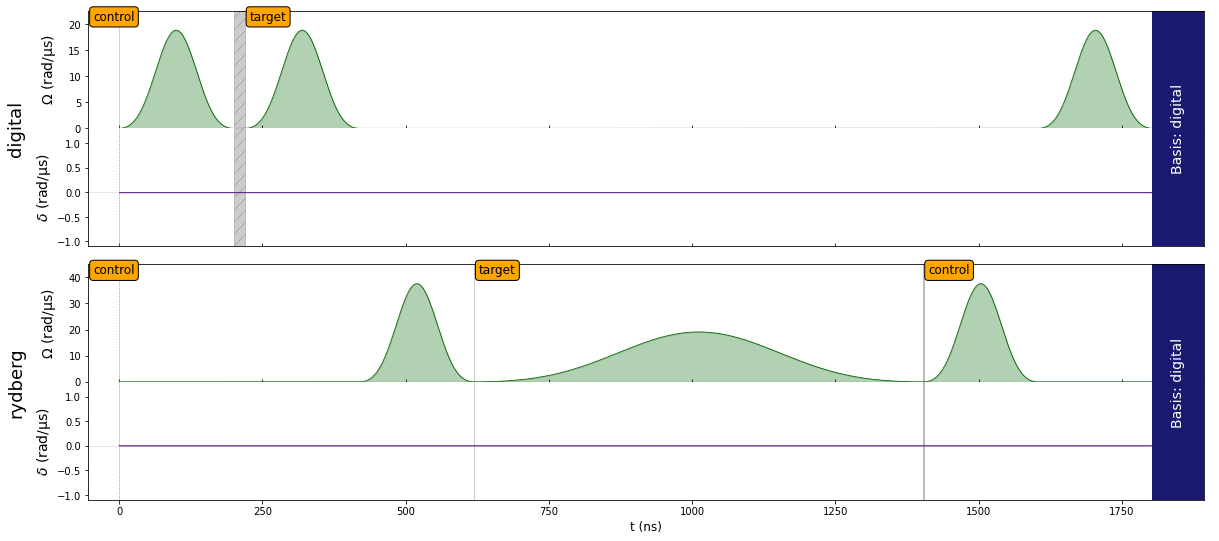

In [6]:
recovered_seq = Sequence.deserialize(s)
recovered_seq.draw()

However, even though they are identical, keep in mind that `seq` and `recovered_seq` are not the same object.

In [ ]:
recovered_seq is seq